In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('feature_outputs/driver_features.csv')
df = df.drop(['index'], axis=1)


#Map Score value for multinominal logistic regression
df['target'] = df['score'].apply(lambda x : 1 if (x >= 0.0) and (x <= 6.0) else (2 if (x > 6.0 and x <= 8.0) else 3))
df['target'] = df['target'].astype('object')

df.head()

,max_speed,max_rotation,max_acc,avg_acc,avg_rotation,avg_speed,min_acc,min_speed,min_rotation,acc_roll_angle,acc_pitch_angle,score,target
0,1.112,3.666944,0.774753,0.341284,0.538582,0.8340,0.137298,0.556,0.057296,-3.791742,-2.157257,8.9,3
1,1.112,6.130672,0.774753,0.331477,1.145920,0.8618,0.098070,0.556,0.057296,5.184349,0.556679,8.9,3
2,1.112,6.130672,0.774753,0.352071,1.736069,0.8896,0.098070,0.556,0.057296,9.335799,-2.366690,8.9,3
3,1.390,10.542464,0.774753,0.355013,2.784586,0.9730,0.098070,0.556,0.057296,6.290228,-2.373949,8.9,3
4,1.390,10.542464,0.774753,0.371685,2.853341,1.0286,0.098070,0.556,0.057296,14.685577,-3.300141,8.9,3


In [3]:
#Putting data in x and y
X =df.iloc[:,0:11]
y= df[['target']].astype('int')


df['target'].value_counts()

2    44491
3    25826
1    21283
Name: target, dtype: int64

#### Logistic Regression

In [4]:
#Modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y,random_state = 0)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)



print(confusion_matrix(y_test, y_pred))
print('\n')
#Accuracy of the model
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))
print('\n')
print(classification_report(y_test, y_pred))

[[1389 2862    6]
 [ 861 5975 2062]
 [ 159 1688 3318]]


Accuracy of logistic regression classifier on test set: 0.58


              precision    recall  f1-score   support

           1       0.58      0.33      0.42      4257
           2       0.57      0.67      0.62      8898
           3       0.62      0.64      0.63      5165

    accuracy                           0.58     18320
   macro avg       0.59      0.55      0.55     18320
weighted avg       0.58      0.58      0.57     18320



### XGB with all columns

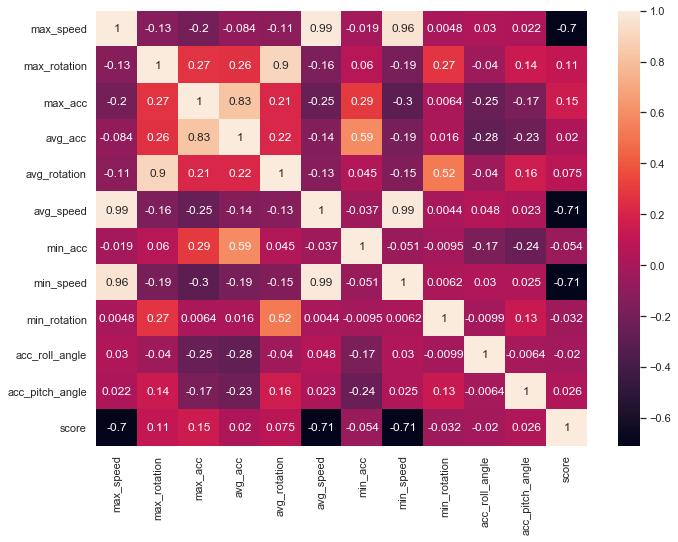

In [5]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11,8)})
Var_Corr = df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

#### Find corelation strength between variables

In [6]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    
    labels_to_drop = pairs_to_drop
    
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [7]:
get_top_abs_correlations(X, n=20)

avg_speed     min_speed          0.989712
max_speed     avg_speed          0.989512
              min_speed          0.962921
max_rotation  avg_rotation       0.900003
max_acc       avg_acc            0.826332
avg_acc       min_acc            0.590391
avg_rotation  min_rotation       0.523658
max_acc       min_speed          0.298715
              min_acc            0.292860
avg_acc       acc_roll_angle     0.278580
max_rotation  min_rotation       0.274247
              max_acc            0.265717
              avg_acc            0.263218
max_acc       acc_roll_angle     0.253592
              avg_speed          0.250585
min_acc       acc_pitch_angle    0.243411
avg_acc       acc_pitch_angle    0.232228
              avg_rotation       0.218175
max_acc       avg_rotation       0.214279
max_speed     max_acc            0.197542
dtype: float64

In [8]:
X =df.iloc[:,0:11]
y= df[['target']]

#converting y into machine readable form [0,1,2]
lab_enc = preprocessing.LabelEncoder()
y= lab_enc.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.25, random_state=10)

In [9]:
df.shape , X_train.shape , y_train.shape,X_test.shape,y_test.shape

((91600, 13), (68700, 11), (68700,), (22900, 11), (22900,))

In [10]:
model= xgb.XGBClassifier(random_state=1,learning_rate=0.01,objective= 'multi:softprob')

model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test,y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 5031   290     0]
 [    0 11123     0]
 [    0     2  6454]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5321
           1       0.97      1.00      0.99     11123
           2       1.00      1.00      1.00      6456

    accuracy                           0.99     22900
   macro avg       0.99      0.98      0.99     22900
weighted avg       0.99      0.99      0.99     22900



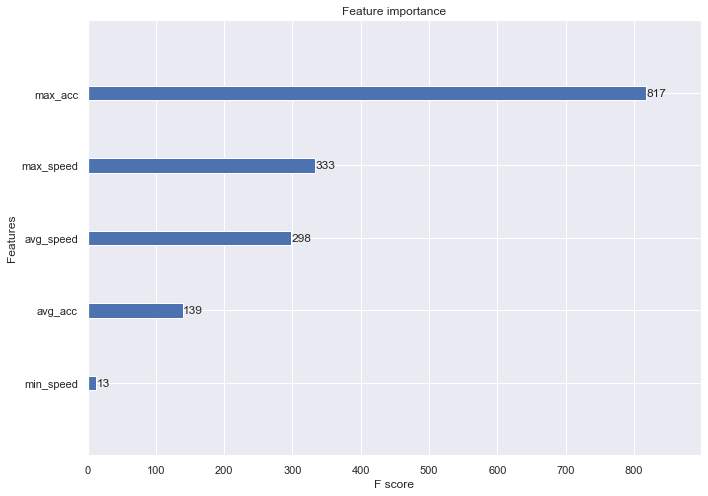

In [11]:
xgb.plot_importance(model)

### LightGBM with all the columns

In [12]:
l = lgb.LGBMClassifier(objective='multiclass')
l.fit(X_train, y_train)
y_pred_lightgbm = l.predict(X_test)

print(confusion_matrix(y_test, y_pred_lightgbm))
print(classification_report(y_test, y_pred_lightgbm))

[[ 5319     2     0]
 [    1 11121     1]
 [    0     1  6455]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5321
           1       1.00      1.00      1.00     11123
           2       1.00      1.00      1.00      6456

    accuracy                           1.00     22900
   macro avg       1.00      1.00      1.00     22900
weighted avg       1.00      1.00      1.00     22900



In [13]:
accuracy_score(y_test,y_pred_lightgbm)

0.9997816593886463